In [1]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import scipy.io, cv2

# Find images path
scene_paths = glob('../Dataset_CNN/*/')

# Fulfill data
X_ = []
y_ = []
Xtest_ = []
ytest_ = []
for scene in scene_paths:
    print(scene)
    windows_path = glob(scene + '*')
    
    for window in windows_path:
        images_ref_path = glob(window + '/w_*.jpg')
        NLF_path = window + '/NLF_filtered.mat'
        
        mat = scipy.io.loadmat(NLF_path)
        NLF = (mat["NLF_step_filt"][0])
        NLF[np.isnan(NLF)] = 0
        
        for img_ref in images_ref_path[0:5]:
            img = plt.imread(img_ref)
            
            X_.append(img)
            y_.append(NLF[0:64])
            
        for img_ref in images_ref_path[6:9]:
            img = plt.imread(img_ref)
            
            Xtest_.append(img)
            ytest_.append(NLF[0:64])
            
        

../Dataset_CNN/Scene_30/
../Dataset_CNN/Scene_35/
../Dataset_CNN/Scene_36/
../Dataset_CNN/Scene_21/
../Dataset_CNN/Scene_33/
../Dataset_CNN/Scene_07/
../Dataset_CNN/Scene_32/
../Dataset_CNN/Scene_34/
../Dataset_CNN/Scene_11/
../Dataset_CNN/Scene_10/
../Dataset_CNN/Scene_13/
../Dataset_CNN/Scene_31/
../Dataset_CNN/Scene_08/
../Dataset_CNN/Scene_23/
../Dataset_CNN/Scene_15/
../Dataset_CNN/Scene_24/
../Dataset_CNN/Scene_19/
../Dataset_CNN/Scene_22/
../Dataset_CNN/Scene_20/
../Dataset_CNN/Scene_12/
../Dataset_CNN/Scene_09/
../Dataset_CNN/Scene_26/
../Dataset_CNN/Scene_06/
../Dataset_CNN/Scene_28/
../Dataset_CNN/Scene_18/
../Dataset_CNN/Scene_29/
../Dataset_CNN/Scene_17/
../Dataset_CNN/Scene_27/
../Dataset_CNN/Scene_16/
../Dataset_CNN/Scene_14/
../Dataset_CNN/Scene_25/
../Dataset_CNN/Scene_05/


In [2]:
X_ = np.asarray(X_)
y_ = np.asarray(y_)

Xtest_ = np.asarray(Xtest_)
ytest_ = np.asarray(ytest_)


In [3]:
print(np.shape(X_))
print(np.shape(y_))
print()
print(np.shape(Xtest_))
print(np.shape(ytest_))

(34560, 256, 256, 3)
(34560, 64)

(20736, 256, 256, 3)
(20736, 64)


### Crear modelo

In [4]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Reshape
from keras.layers import concatenate, AveragePooling2D, Activation, BatchNormalization
from keras.models import Model
from SpatialPyramidPooling import SpatialPyramidPooling
import keras
# First, define the vision modules
input_imgs = Input(shape=(256, 256, 3))

# Model
def get_model_column(ks_1, ks_2,p_):
    x = Conv2D(64, kernel_size=(ks_1,ks_1), strides = 2, activation=None)(input_imgs)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = AveragePooling2D((2, 2))(x)
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = AveragePooling2D((2, 2))(x) # pool2_a
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    #out = keras.layers.ZeroPadding2D(padding=((p_, 0), (0, p_)), data_format=None)(x)
    out = Flatten()(x)
    return out

vision_model1 = Model(input_imgs, get_model_column(5, 3, 0))
vision_model2 = Model(input_imgs, get_model_column(7, 5, 5))
vision_model3 = Model(input_imgs, get_model_column(9, 7, 10))

# Then define the input-apart model
input_a = Input(shape=(256, 256, 3))
input_b = Input(shape=(256, 256, 3)) #shape=(300, 300, 3))
input_c = Input(shape=(256, 256, 3)) #shape=(340, 340, 3))

# The vision model will be shared, weights and all
out_a = vision_model1(input_a)
out_b = vision_model2(input_b)
out_c = vision_model3(input_c)

concatenated = concatenate([out_a, out_b, out_c],axis=1)
#out = Dense(1, activation='sigmoid')(concatenated)
#merge_abc = SpatialPyramidPooling([1, 2, 4])(concatenated)
merge_abc = Dense(2048, activation='tanh')(concatenated)
#merge_abc = Dense(256*3, activation='relu')(merge_abc)
merge_abc = Dense(64, activation='relu')(merge_abc)

model_abc = Model([input_a, input_b, input_c], merge_abc)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [5]:
vision_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 64)      4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 64)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
__________

In [6]:
model_abc.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 43264)        116672      input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (M

### Training

In [7]:
from keras import optimizers
from keras import losses

sgd = optimizers.SGD(lr=0.001, decay=0.0001, momentum=0.9, nesterov=True)

# compile model (abc)
model_abc.compile(optimizer= sgd, loss='mse')
#model_abc.compile(optimizer= sgd, loss=losses.kullback_leibler_divergence)


In [9]:
# Make model_a non trainable
model_abc.layers[3].trainable = False
model_abc.layers[4].trainable = False
#model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=64, epochs=10, validation_split=0.1, shuffle=True)
model_abc.fit(x=[X_,X_,X_], y=y_, validation_data=([Xtest_,Xtest_,Xtest_], ytest_),batch_size=64, epochs=30, shuffle=True)

# Make model_a non trainable
model_abc.layers[3].trainable = False
model_abc.layers[4].trainable = True
model_abc.layers[5].trainable = False
#model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=64, epochs=10, validation_split=0.1, shuffle=True)
model_abc.fit(x=[X_,X_,X_], y=y_, validation_data=([Xtest_,Xtest_,Xtest_], ytest_),batch_size=64, epochs=30, shuffle=True)

# Make model_a non trainable
model_abc.layers[3].trainable = True
model_abc.layers[4].trainable = False
model_abc.layers[5].trainable = False
#model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=64, epochs=10, validation_split=0.1, shuffle=True)
model_abc.fit(x=[X_,X_,X_], y=y_, validation_data=([Xtest_,Xtest_,Xtest_], ytest_),batch_size=64, epochs=30, shuffle=True)


Train on 34560 samples, validate on 20736 samples
Epoch 1/30
   64/34560 [..............................] - ETA: 1:31 - loss: 3.8186e-04

/home/plyzer-ai/anaconda3/envs/carlus/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


34560/34560 [==============================] - 110s 3ms/step - loss: 4.8803e-04 - val_loss: 1.1369
Epoch 2/30
34560/34560 [==============================] - 110s 3ms/step - loss: 4.5861e-04 - val_loss: 1.0199
Epoch 3/30
34560/34560 [==============================] - 110s 3ms/step - loss: 4.2315e-04 - val_loss: 1.0926
Epoch 4/30
34560/34560 [==============================] - 110s 3ms/step - loss: 3.7964e-04 - val_loss: 1.1460
Epoch 5/30
34560/34560 [==============================] - 110s 3ms/step - loss: 3.6571e-04 - val_loss: 1.0633
Epoch 6/30
34560/34560 [==============================] - 110s 3ms/step - loss: 3.3540e-04 - val_loss: 1.1090
Epoch 7/30
34560/34560 [==============================] - 110s 3ms/step - loss: 3.4132e-04 - val_loss: 1.1219
Epoch 8/30
34560/34560 [==============================] - 110s 3ms/step - loss: 3.4546e-04 - val_loss: 1.0459
Epoch 9/30
34560/34560 [==============================] - 110s 3ms/step - loss: 3.3288e-04 - val_loss: 1.1980
Epoch 10/30
34560/345

34560/34560 [==============================] - 111s 3ms/step - loss: 2.3860e-04 - val_loss: 1.1030
Epoch 15/30
34560/34560 [==============================] - 111s 3ms/step - loss: 2.3778e-04 - val_loss: 1.1213
Epoch 16/30
34560/34560 [==============================] - 111s 3ms/step - loss: 2.3961e-04 - val_loss: 1.0935
Epoch 17/30
34560/34560 [==============================] - 111s 3ms/step - loss: 2.3986e-04 - val_loss: 1.1158
Epoch 18/30
34560/34560 [==============================] - 111s 3ms/step - loss: 2.4512e-04 - val_loss: 1.1263
Epoch 19/30
34560/34560 [==============================] - 111s 3ms/step - loss: 2.3974e-04 - val_loss: 1.0994
Epoch 20/30
34560/34560 [==============================] - 111s 3ms/step - loss: 2.4374e-04 - val_loss: 1.0998
Epoch 21/30
34560/34560 [==============================] - 111s 3ms/step - loss: 2.4192e-04 - val_loss: 1.1298
Epoch 22/30
34560/34560 [==============================] - 112s 3ms/step - loss: 2.4081e-04 - val_loss: 1.1145
Epoch 23/30
3

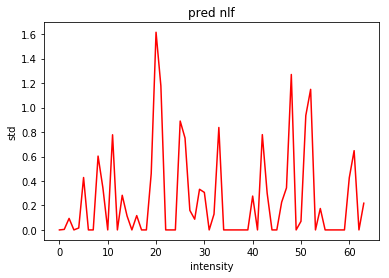

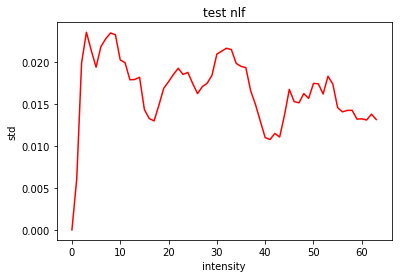

In [6]:
import matplotlib.pyplot as plt
ii = 20
y_pred = np.transpose(model_abc.predict([[X_[ii]],[X_[ii]],[X_[ii]]]))

fig, ax = plt.subplots()
#y_pred[y_pred < 0] = 0
ax.plot(y_pred,'r')

ax.set(xlabel='intensity', ylabel='std',
       title='pred nlf')
plt.show()

fig, ax = plt.subplots()
ax.plot(y_[ii],'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf')
plt.show()

In [ ]:
print(y_[0])

In [ ]:
from keras.utils import plot_model

plot_model(model_abc, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import scipy.io


scene = 'Scene_21'
nlf_path = '../Dataset_Final/NLFs/NLF_' + scene + '.mat'
mat = scipy.io.loadmat('../Dataset_Final/NLFs/NLF_' + scene + '.mat')
NLF = mat["NLF"][0]
NLF_r = np.nan_to_num(NLF[0:256])

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y,b,a

order = 5
fs = 30    # sample rate, Hz
cutoff = 2
y,b,a = butter_lowpass_filter(NLF_r, cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)

plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

fig, ax = plt.subplots()
ax.plot(y,'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf filtered')
plt.show()

fig, ax = plt.subplots()
ax.plot(NLF_r,'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf')
plt.show()